# Notebook for comparing the model of dipole vs. quadrupole for ca. 1083-1084 Ma

- Sears, J. W. (2022). Challenging the dipolar paradigm for Proterozoic Earth. Presented based on debatable geologic links that the Siberia craton and the southwestern Laurentia craton were connected in the early Proterozoic. Based on this connection he argued that the combined paleomagnetic data from the two cratons at the time indicate that the geomagnetic field at the time was likely to be quadrupole dominated.

- Gong et al., 2023, on the other hand, argued that a dipole model is better, if not equally, good fit for the available paleomagnetic directional data from Laurentia, and Laurentia+Baltica through the Proterozoic. Their model is based on a frequentist's approach which exhaust search for the dipole or quadrupole configuration by grids on a sphere surface that result in the smallest least squares misfit for the observed paleomagnetic directional data. 

## import python libraries

In [1]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag

import cartopy.crs as ccrs

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Let's first see what a dipole and a quadrupole look like

- according to Knappe, 1980, On Modeling Magnetic Fields on a Sphere with Dipoles and Quadrupoles, we can visualize the inclinations and declinations of a dipole and a quadrupole on a sphere surface as follows

In [2]:
# Define the polar coordinates
lons = np.linspace(0, 2*np.pi, 50)
lats = np.linspace(-np.pi/2, np.pi/2, 25)
lons, lats = np.meshgrid(lons, lats)

### dipole

In [3]:
# calculate inclination at each point
dipole_incs = np.degrees(np.arctan(2*np.tan(lats)))

# delcination does not matter for the dipole case since everywhere it should be pointing north

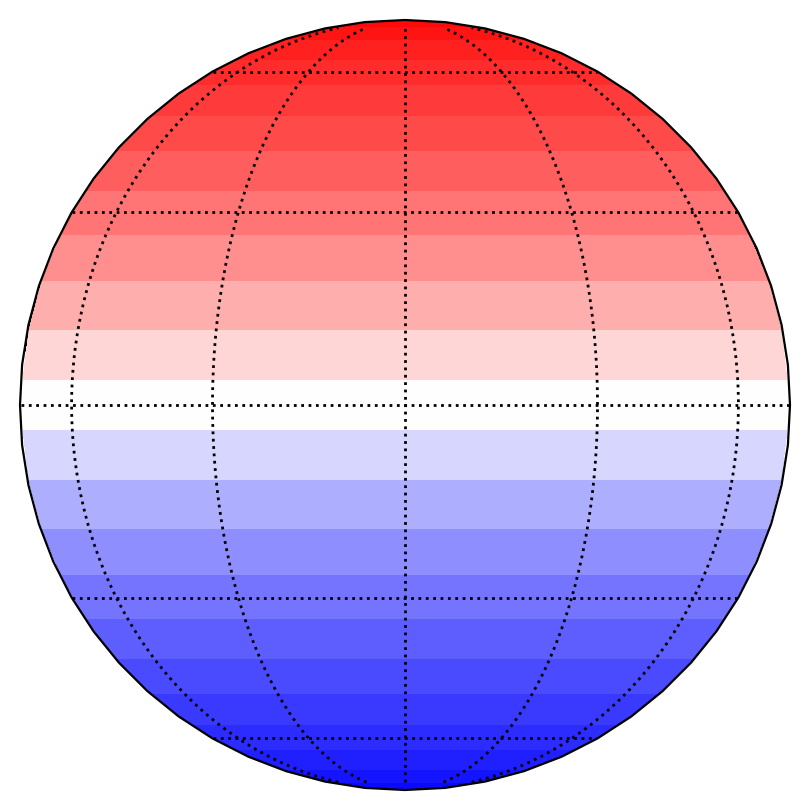

In [4]:
# illustrate the inclinations

ax = ipmag.make_orthographic_map(figsize=(5,5), central_latitude=0, central_longitude=0)

ax.pcolormesh(np.degrees(lons), np.degrees(lats), dipole_incs, vmin=np.min(dipole_incs), vmax=np.max(dipole_incs), 
              cmap='bwr', transform=ccrs.PlateCarree())

plt.show()

### Let's illustrate the quadrupole model

- according to Knapp's definition, a quadrupole can be characterized by the direction in which the reversed dipole is displaced from the forward one. This classification can be done using the characteristic angle 2$\omega$ which is the angle at the normal pole between two reversed poles. If this angle is 180, then we have a linear quadrupole: 

<img src="linear_quadrupole.png" alt="isolated" width="600"/>

If this angle is neither zero or multiple of 90, then we have a rhombic quadrupole:
<img src="rhombic_quadrupole.png" alt="isolated" width="800"/>

All images are taken from Knapp, 1980.


- if the angle is 90, then we have a normal quadrupole, which we will illustrate below with code. 

<img src="normal_quadrupole.png" alt="isolated" width="200"/>


In [5]:
# makes a function that calculates the inclination for
# a given longitude and latitude based on a normal quadrupole model
def normal_quadrupole_inclination(lon, lat):
    colat = np.pi/2 - lat
    # tan_I = -1.5*(1/np.sqrt((1/np.sin(colat)**2*1/np.cos(2*lon)**2-1)))
    tan_I = -1.5*(np.sin(colat)*np.cos(2*lon))/(2*(1-np.sin(colat)**2*np.cos(2*lon)**2)**0.5)
    I = np.degrees(np.arctan(tan_I))
    return I

# makes a function that calculates the inclination for 
# a given longitude and latitude based on a negative linear quadrupole model
def negative_linear_quadrupole_inclination(lon, lat):
    lat = np.radians(lat)
    lon = np.radians(lon)
    colat = np.pi/2 - lat
    tan_I = (3*np.cos(2*colat)+1)/np.abs((2*np.sin(2*colat)))
    I = np.degrees(np.arctan(tan_I))
    return I

In [6]:
# calculate inclination at each point
normal_quadrupole_incs = normal_quadrupole_inclination(lons, lats)
negative_quadrupole_incs = negative_linear_quadrupole_inclination(lons, lats)

# normal_quadrupole_incs

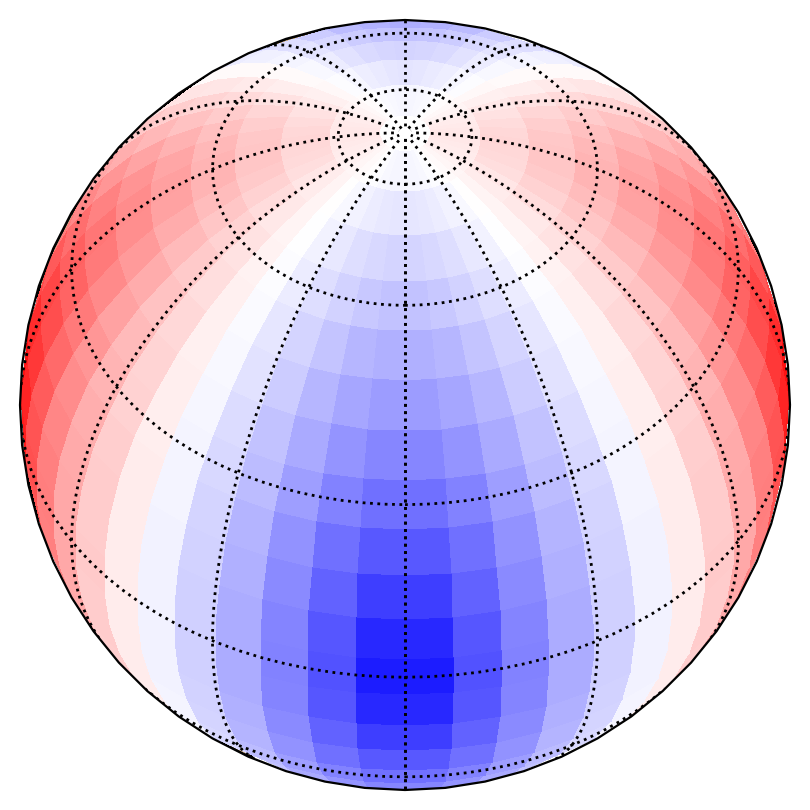

In [7]:
# illustrate the inclinations of a normal quadrupole

ax = ipmag.make_orthographic_map(figsize=(5,5), central_latitude=45, central_longitude=180)

ax.pcolormesh(np.degrees(lons), np.degrees(lats), normal_quadrupole_incs, 
              vmin=np.min(normal_quadrupole_incs), vmax=np.max(normal_quadrupole_incs), 
              cmap='bwr', transform=ccrs.PlateCarree())

plt.show()

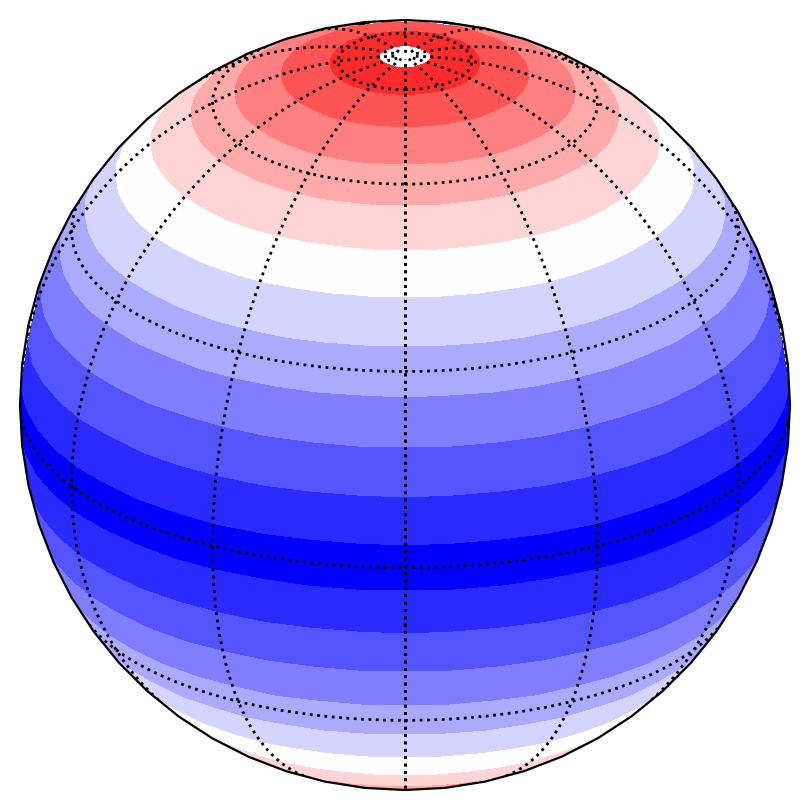

In [8]:
# illustrate the inclinations of a negative linear quadrupole

ax = ipmag.make_orthographic_map(figsize=(5,5), central_latitude=25, central_longitude=180)

ax.pcolormesh(np.degrees(lons), np.degrees(lats), negative_quadrupole_incs, 
              vmin=np.min(negative_quadrupole_incs), vmax=np.max(negative_quadrupole_incs), 
              cmap='bwr', transform=ccrs.PlateCarree())

plt.show()

## The goal is to see whether a dipole or a normal quadrupole model better fits the observed directions at different locations on the Earth's surface

- The ca. 1084 Ma Michipicotan pole and the ca. 1082 Ma Cardenas Basalt pole presents us with this opportunity to investigate the models since they are close in time but ~2000 km apart in space. 

- The age of the Michipicoten Island Formation pole is bracketed in age between 1084.35 ± 0.20 Ma and 1083.52 ± 0.23 Ma.

- The age of the Cardenas Basalt pole is dated to be 1082.18 ± 1.25 Ma.

In [102]:
Mich_slat = 47.7
Mich_slon = 360-85.7

Mich_dir_dec = 287.6
Mich_dir_inc = 10.3
Mich_dir_a95 = 5.4
Mich_dir_k = 35.2

CB_slat = 36.1
CB_slon = 360-112.0

CB_dir_dec = 268.5
CB_dir_inc = 46.4
CB_dir_a95 = 7.9
CB_dir_k = 20.2


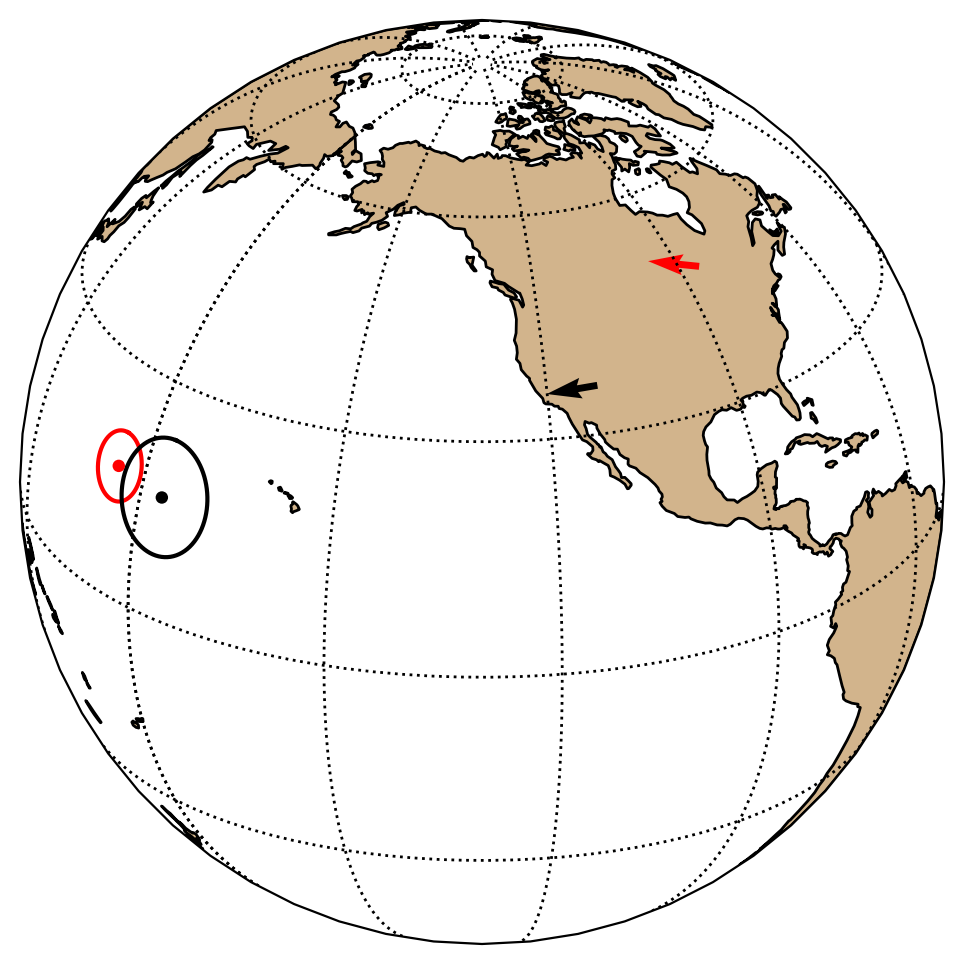

In [103]:
ax = ipmag.make_orthographic_map(figsize=(6,6), central_latitude=25, central_longitude=-130)

# now let's plot the declination of the directions at each site as a vector

ax.quiver(np.array([Mich_slon]), np.array([Mich_slat]), np.array([np.sin(np.radians(Mich_dir_dec))]), np.array([np.cos(np.radians(Mich_dir_dec))]),
            color='r', transform=ccrs.PlateCarree())
ax.quiver(np.array([CB_slon]), np.array([CB_slat]), np.array([np.sin(np.radians(CB_dir_dec))]), np.array([np.cos(np.radians(CB_dir_dec))]),
            color='k', transform=ccrs.PlateCarree())
# ax.plot([-174.7, Mich_slon], [17.0, Mich_slat], color='k', transform=ccrs.Geodetic())

ipmag.plot_pole(ax, 174.7, 17.0, 4.4, color='r', edgecolor='none')
ipmag.plot_pole(ax, 183.9, 15.9, 7.4, color='k', edgecolor='none')
plt.show()

In [104]:
d2r = np.pi/180
r2d = 180/np.pi

def calculate_azimuth(observer_latitude, observer_longitude, target_latitude, target_longitude):
    # Convert degrees to radians
    observer_latitude = observer_latitude*d2r
    observer_longitude = observer_longitude*d2r
    target_latitude = target_latitude*d2r
    target_longitude = target_longitude*d2r

    # Calculate the difference in longitudes
    delta_longitude = target_longitude - observer_longitude

    # Calculate azimuth using spherical trigonometry
    x = np.sin(delta_longitude)
    y = np.cos(observer_latitude) * np.tan(target_latitude) - np.sin(observer_latitude) * np.cos(delta_longitude)
    azimuth = np.arctan(x/y)
    # azimuth = np.arctan2(x, y)
    # Convert the result to degrees and normalize it to [0, 360) range
    
    return azimuth

def calc_angle(lon1, lat1, lon2, lat2):
    cart1 = spherical_to_cartesian(lon1, lat1)
    cart2 = spherical_to_cartesian(lon2, lat2)
    angle = np.arccos(np.dot(cart1, cart2)) * r2d
    angle = angle % 360.

    return angle

def calc_pinc(lat):
    tanl = np.tan(lat*d2r)
    inc = np.arctan(2. * tanl)
    return r2d*inc

In [105]:
calculate_azimuth(CB_slat, CB_slon, 15.9, 183.9)

268.26806750256117

In [106]:
calculate_azimuth(Mich_slat, Mich_slon, 17, 174.7)

288.4580919853298

## Now let's invert for the best fit dipole location using bayesian_pep

In [95]:
from bayesian_pep import*

In [113]:
with pm.Model() as model:
    # let's define a prior for the dipole location with a Watson girdle with very small k 
    dipole_axis = Watson_Girdle('dipole_axis', lon_lat = [1.,1.], k=-0.1, testval = np.array([1., 1.]), shape = 2)

    # with this dipole location, we can then calculate the colatitude of at the sites
    Mich_pred_dec = calculate_azimuth(Mich_slat, Mich_slon, dipole_axis[1], dipole_axis[0])%180 + 180
    
    Michi_lat = 90-calc_angle(dipole_axis[0], dipole_axis[1], Mich_slon, Mich_slat)
    Mich_pred_inc = -calc_pinc(Michi_lat)

    observed_dir = VMF('dir_Mich', [Mich_pred_dec, Mich_pred_inc], k = Mich_dir_k, observed=[Mich_dir_dec, Mich_dir_inc])

    CB_pred_dec = calculate_azimuth(CB_slat, CB_slon, dipole_axis[1], dipole_axis[0])%180 + 180
    
    CB_lat = 90-calc_angle(dipole_axis[0], dipole_axis[1], CB_slon, CB_slat)
    CB_pred_inc = -calc_pinc(CB_lat)

    observed_dir = VMF('dir_CB', [CB_pred_dec, CB_pred_inc], k = CB_dir_k, observed=[CB_dir_dec, CB_dir_inc])
      
    #uncomment to run the model
    trace_dipole = pm.sample(20000, tune=10000, step = pm.Metropolis(), cores=12, chains=4, init='auto')

Multiprocess sampling (4 chains in 12 jobs)
Metropolis: [dipole_axis]


Sampling 4 chains for 10_000 tune and 20_000 draw iterations (40_000 + 80_000 draws total) took 62 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [116]:
pm.save_trace(trace_dipole, 'code_output/dipole_trace', overwrite=1)

'code_output/dipole_trace'

In [117]:
dipole_trace_saved = pm.load_trace('code_output/dipole_trace',model)

In [118]:
dipole_axis_resample = dipole_trace_saved[dipole_axis]

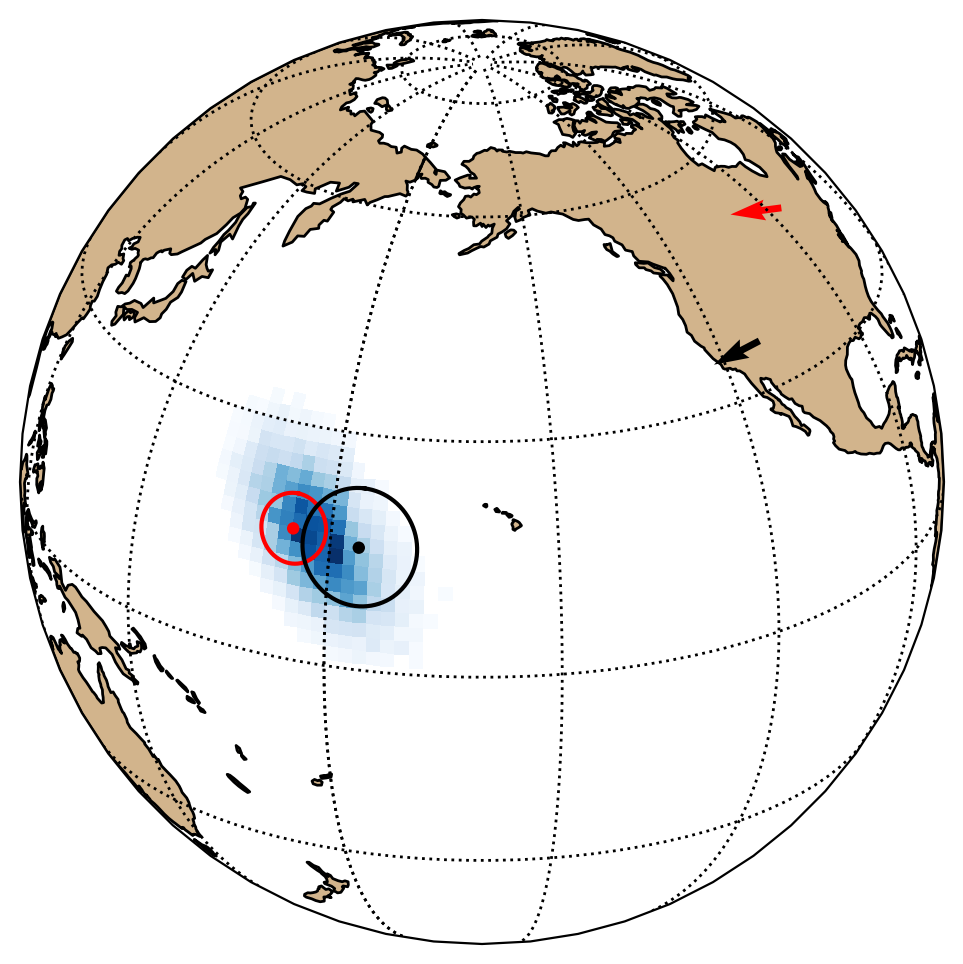

In [120]:
ax = ipmag.make_orthographic_map(figsize=(6,6), central_latitude=25, central_longitude=-160)

# now let's plot the declination of the directions at each site as a vector

ax.quiver(np.array([Mich_slon]), np.array([Mich_slat]), np.array([np.sin(np.radians(Mich_dir_dec))]), np.array([np.cos(np.radians(Mich_dir_dec))]),
            color='r', transform=ccrs.PlateCarree())
ax.quiver(np.array([CB_slon]), np.array([CB_slat]), np.array([np.sin(np.radians(CB_dir_dec))]), np.array([np.cos(np.radians(CB_dir_dec))]),
            color='k', transform=ccrs.PlateCarree())
# ax.plot([-174.7, Mich_slon], [17.0, Mich_slat], color='k', transform=ccrs.Geodetic())

plot_distributions(ax, dipole_axis_resample.T[0]+180, -dipole_axis_resample.T[1], cmap='Blues', resolution=100)

ipmag.plot_pole(ax, 174.7, 17.0, 4.4, color='r', edgecolor='none')
ipmag.plot_pole(ax, 183.9, 15.9, 7.4, color='k', edgecolor='none')
plt.show()

## Now let's invert for the best fit normal quadrupole location using bayesian_pep